# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* ~~визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)~~
* ~~аналогично исследовать скопления голосов за и против отдельно~~
* ~~*подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*~~
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

In [2]:
geo_df = pd.read_excel('geo.xlsx', index_col=0, engine='openpyxl')

geo_df.info()
geo_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108806 entries, 0 to 108805
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   x              108806 non-null  float64
 1   y              108806 non-null  float64
 2   comment_class  108806 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 3.3 MB


,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1
...,...,...,...
108801,37.454528,55.792331,-1
108802,37.384325,55.899068,-1
108803,37.421066,55.848756,1
108804,37.448509,55.793065,-1


In [3]:
geo_comment_df = pd.read_excel('geo_comment.xlsx', index_col=0, engine='openpyxl')

geo_comment_df.info()
geo_comment_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70382 entries, 0 to 70381
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              70382 non-null  float64
 1   y              70382 non-null  float64
 2   comment_class  70382 non-null  int64  
 3   multiplier     70382 non-null  int64  
 4   comment        70382 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 3.2+ MB


,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...
...,...,...,...,...,...
70377,37.454528,55.792331,-1,1,Не поддерживаю. Я против строительства многоэт...
70378,37.384325,55.899068,-1,1,Не поддерживаю. Не нужны отстойники автобусов ...
70379,37.421066,55.848756,1,1,"Не поддерживаю. На мой взгляд, необходимо искл..."
70380,37.448509,55.793065,-1,1,Не поддерживаю: нарушения при строительстве н...


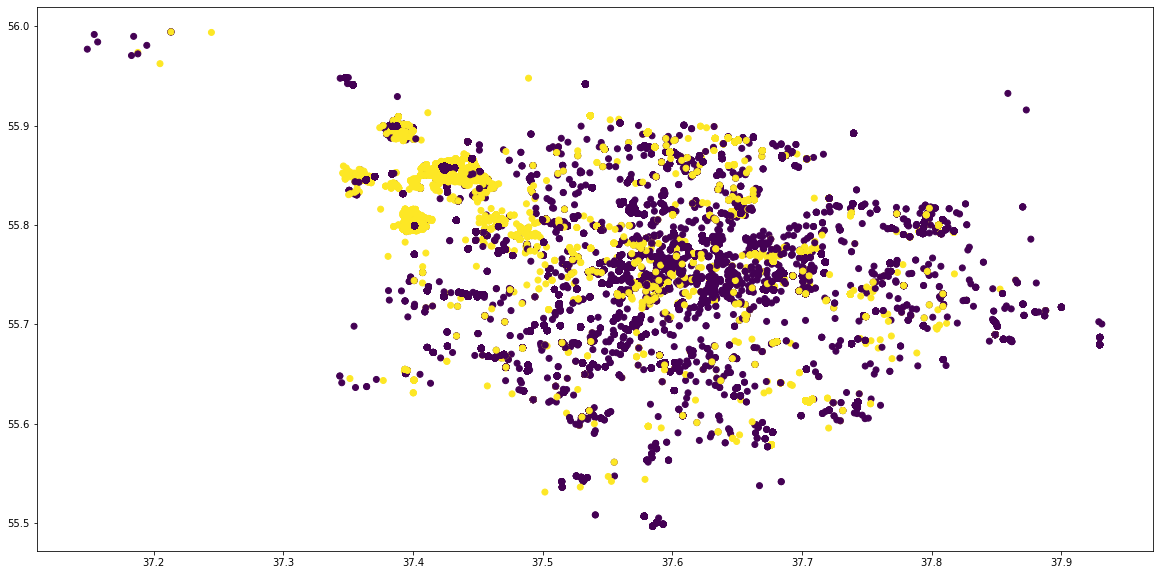

In [4]:
plt.scatter(geo_df['x'], geo_df['y'], c=geo_df['comment_class'])

plt.show()

## Визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)

In [5]:
X = geo_df[['x', 'y']]

X

,x,y
0,37.612416,55.777454
1,37.612416,55.777454
2,37.603298,55.742108
3,37.558526,55.728758
4,37.566431,55.731794
...,...,...
108801,37.454528,55.792331
108802,37.384325,55.899068
108803,37.421066,55.848756
108804,37.448509,55.793065


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled

array([[ 0.36791896,  0.15955291],
       [ 0.36791896,  0.15955291],
       [ 0.2931784 , -0.34813064],
       ...,
       [-1.20058354,  1.1836816 ],
       [-0.97563233,  0.38377766],
       [-0.95317246,  1.00936916]])

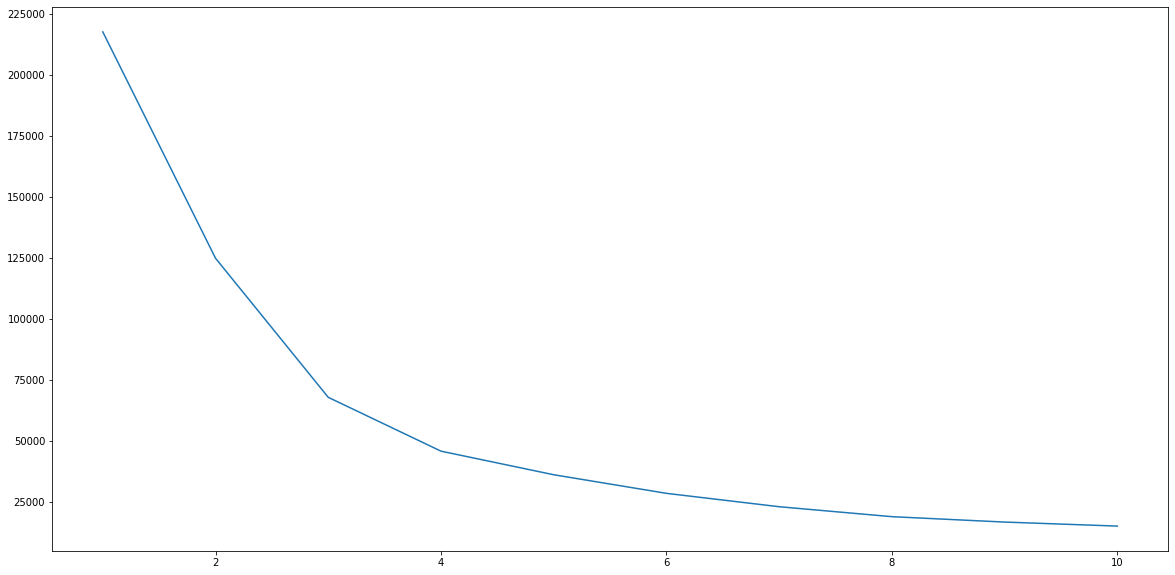

In [7]:
from sklearn.cluster import KMeans

k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled)
    k_inertia.append(clf_kmeans.inertia_)

plt.plot(ks, k_inertia)

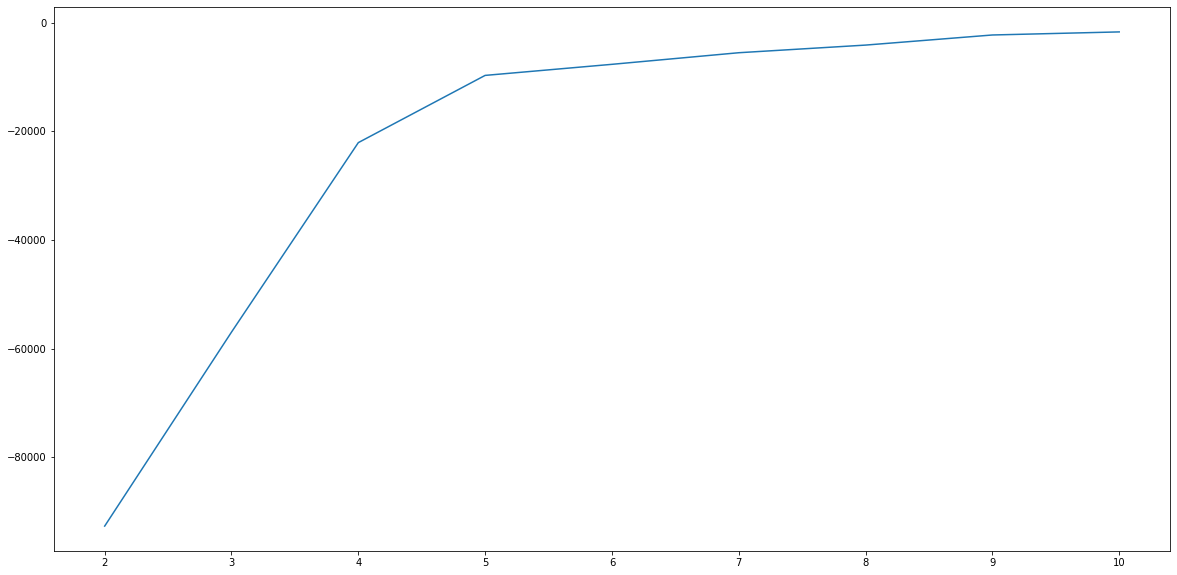

In [8]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

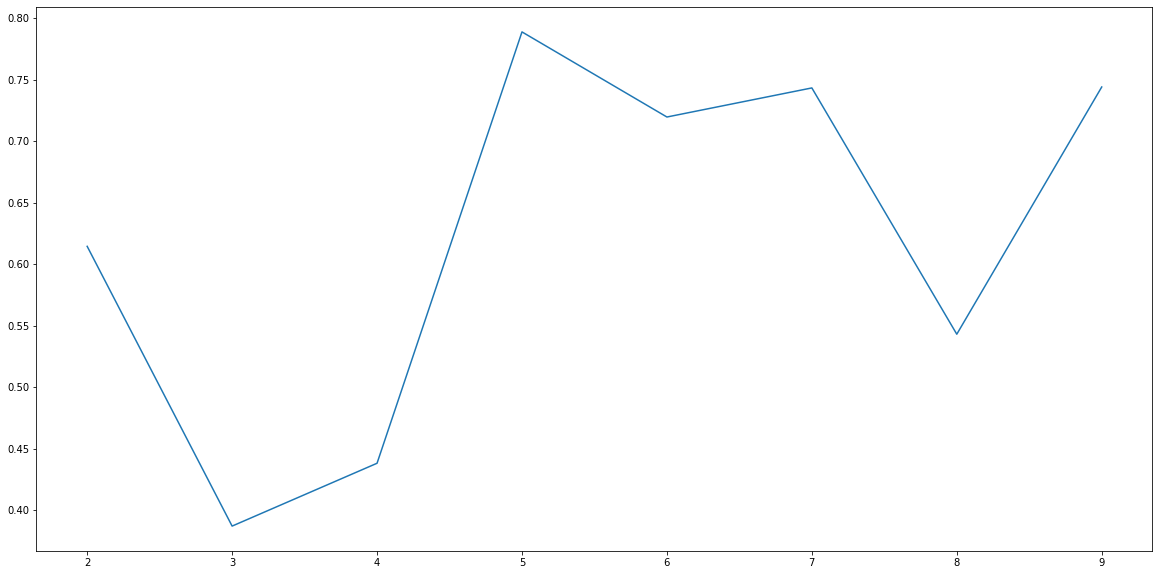

In [9]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [10]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

In [11]:
kmeans = KMeans(n_clusters=k_opt)
kmeans.fit(X_scaled)

KMeans(n_clusters=3)

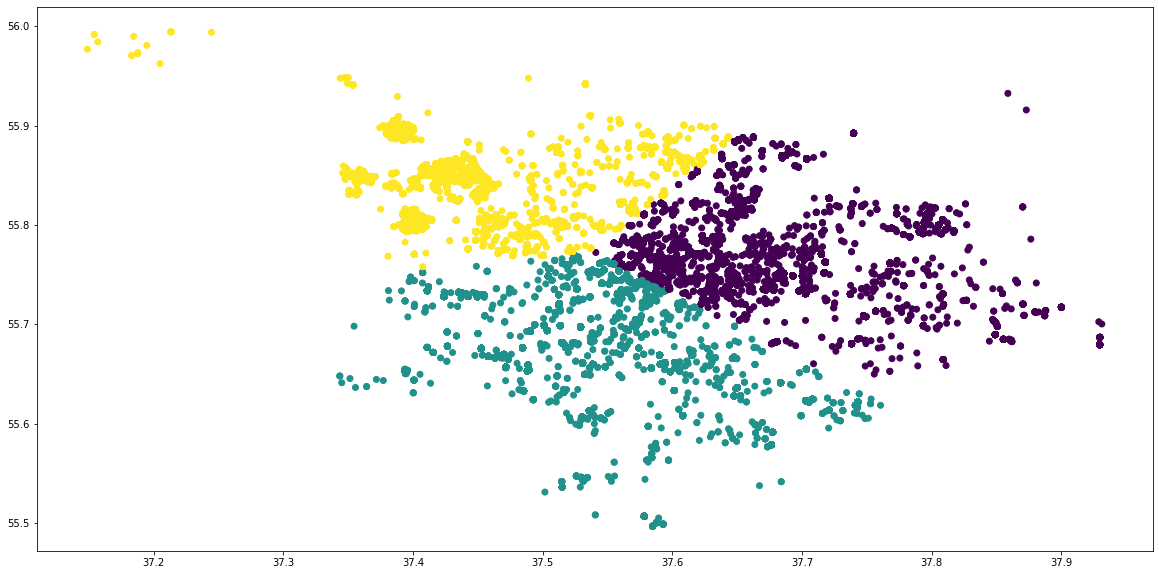

In [12]:
plt.scatter(geo_df['x'], geo_df['y'], c=kmeans.labels_)

plt.show()

## Найти наиболее активные в голосовании районы (подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')

## Аналогично исследовать скопления голосов за

In [13]:
X = geo_df[geo_df['comment_class'] == 1][['x', 'y']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled

array([[-0.16701157, -0.66683515],
       [-0.1640515 , -0.79116702],
       [-0.3947497 , -0.88011374],
       ...,
       [-1.19866757,  0.85950028],
       [-1.17409523,  0.14520085],
       [-1.42485448,  1.05523145]])

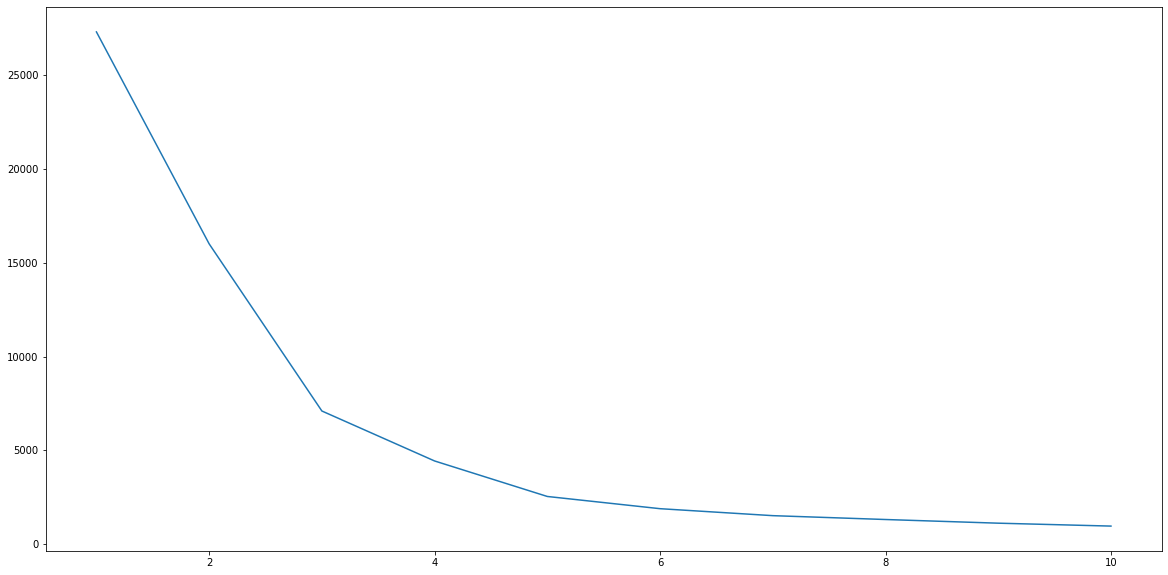

In [14]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled)
    k_inertia.append(clf_kmeans.inertia_)

plt.plot(ks, k_inertia)

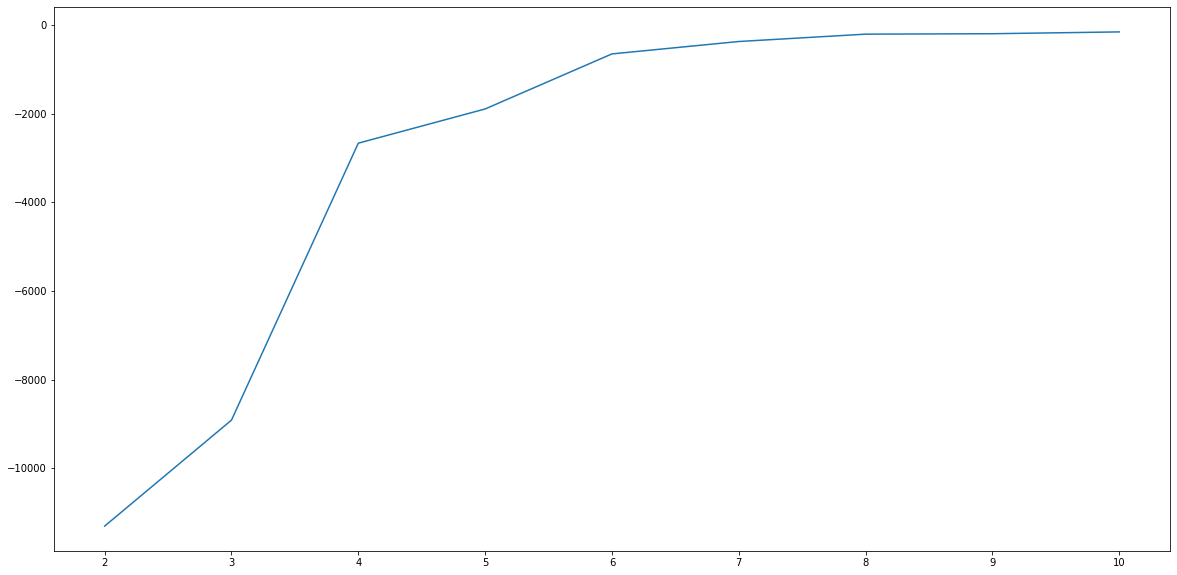

In [15]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

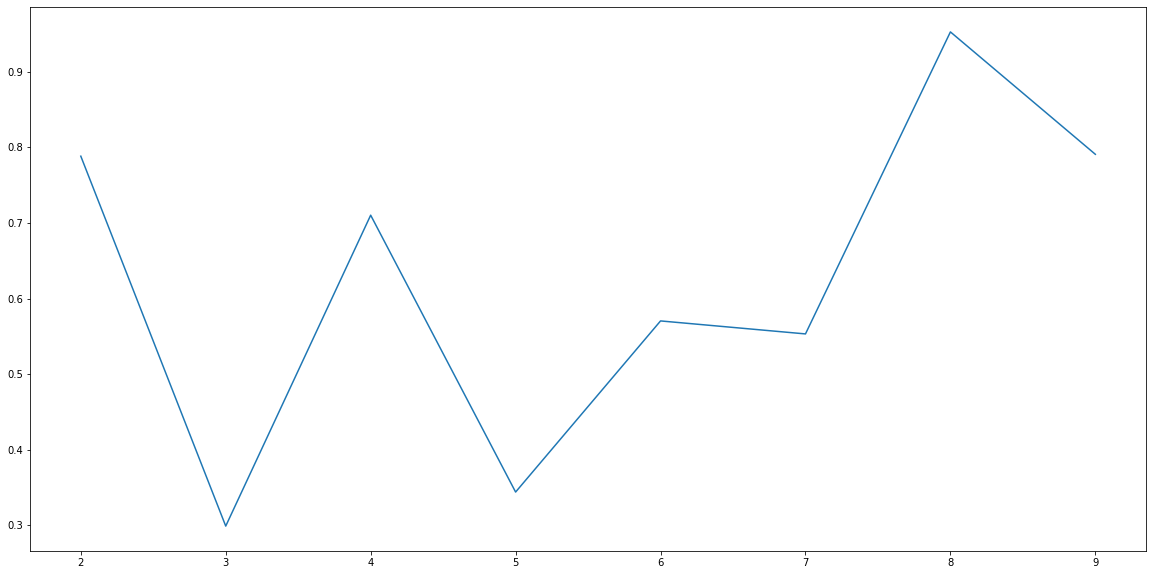

In [16]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [17]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

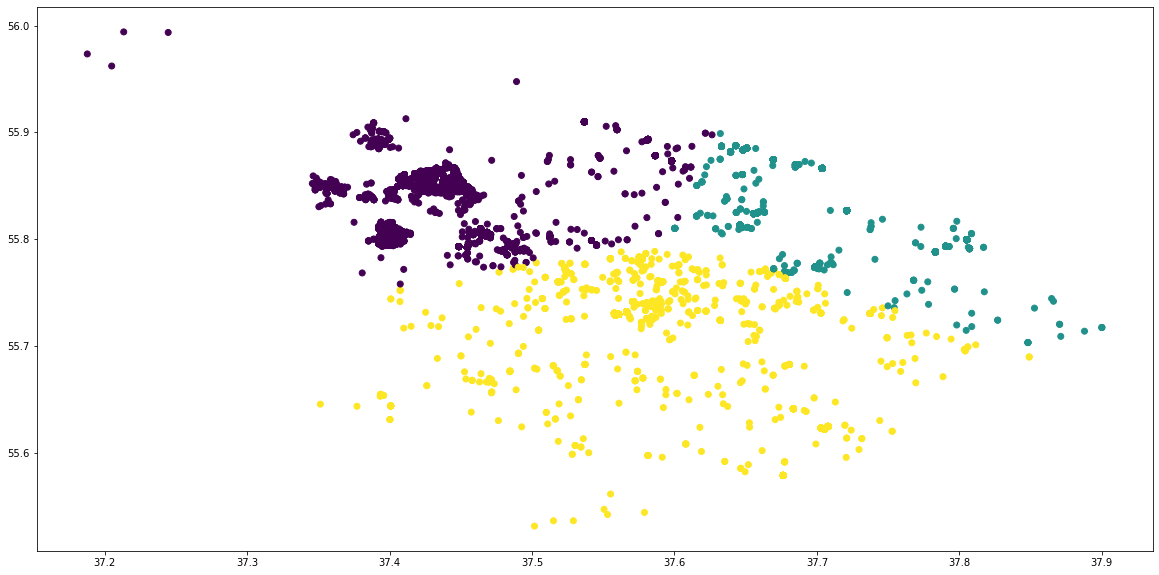

In [18]:
kmeans = KMeans(n_clusters=k_opt)
kmeans.fit(X_scaled)

plt.scatter(X['x'], X['y'], c=kmeans.labels_)
plt.show()

## Аналогично исследовать скопления голосов против

In [19]:
X = geo_df[geo_df['comment_class'] == -1][['x', 'y']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled

array([[ 0.43002964,  0.19265922],
       [ 0.43002964,  0.19265922],
       [ 0.35337802, -0.31003917],
       ...,
       [-1.4874462 ,  1.92227958],
       [-0.94787529,  0.4146822 ],
       [-0.92484113,  1.03413074]])

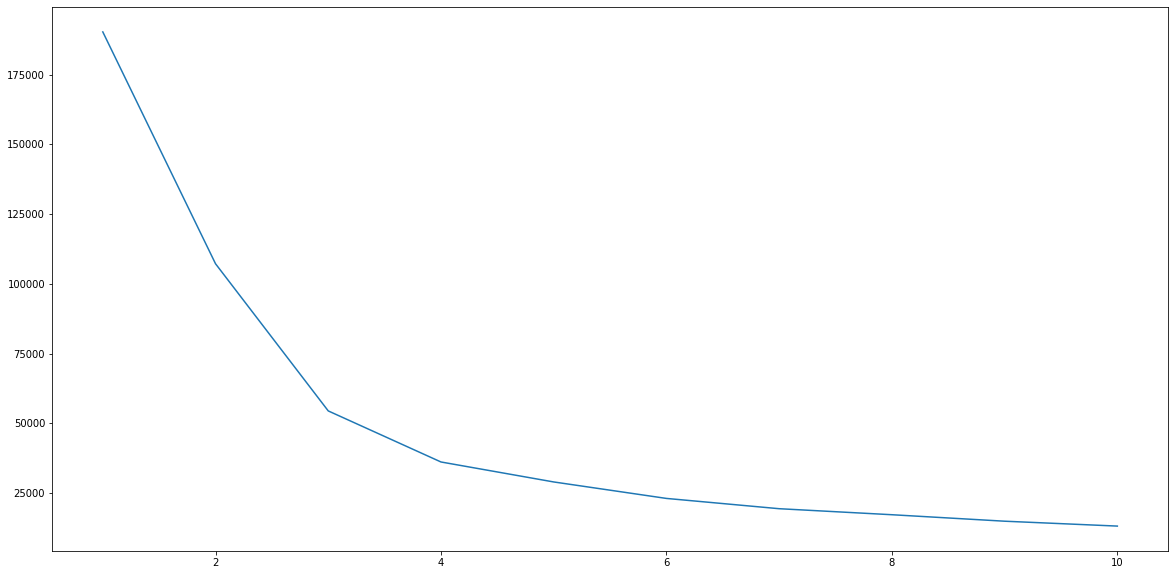

In [20]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled)
    k_inertia.append(clf_kmeans.inertia_)

plt.plot(ks, k_inertia)

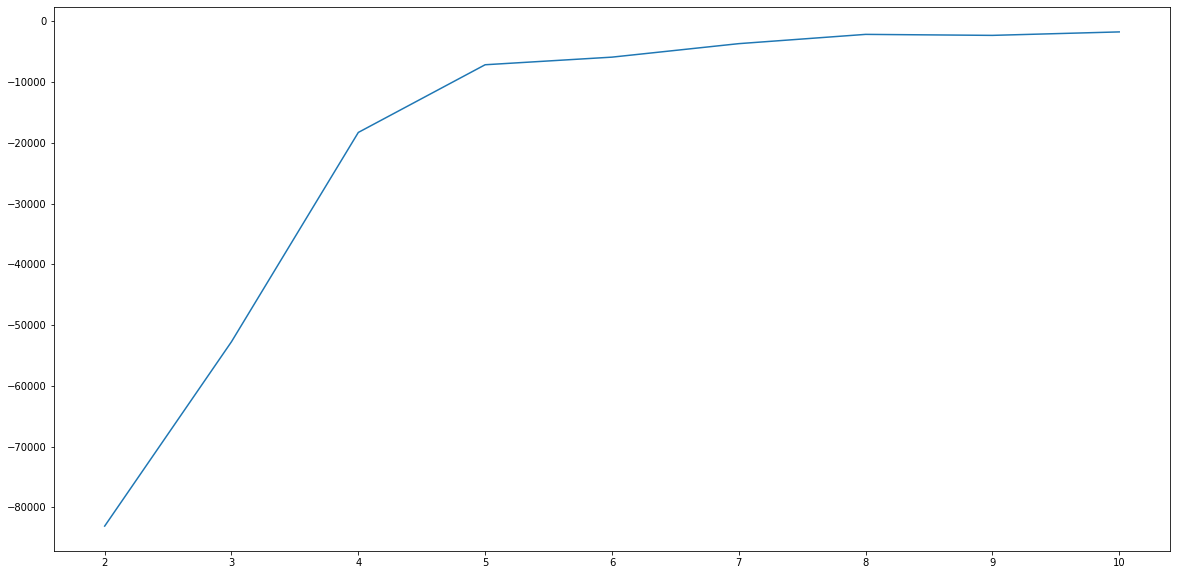

In [21]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

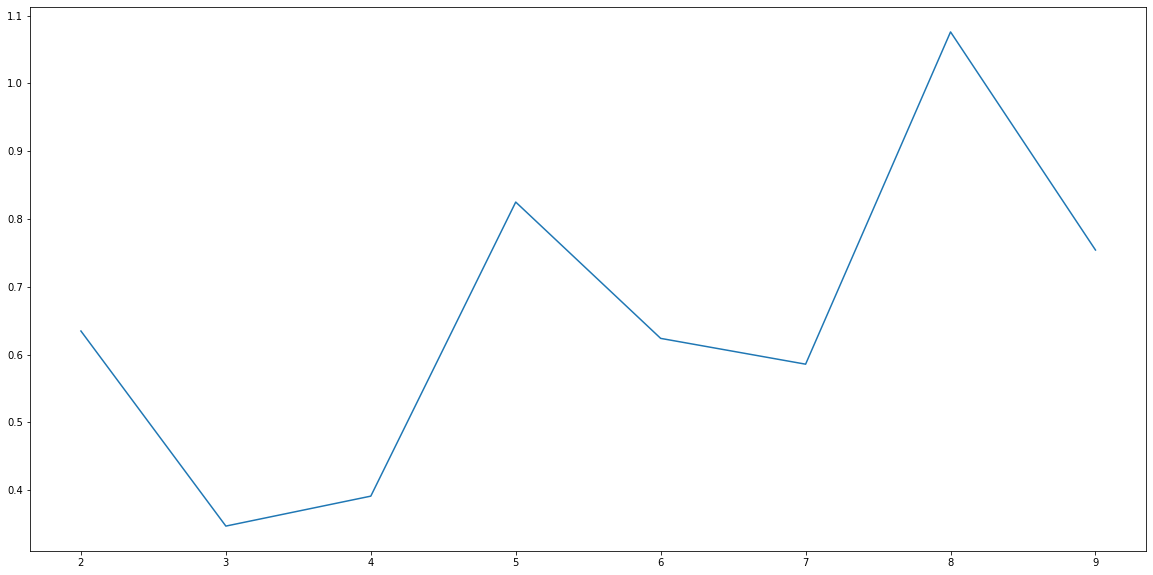

In [22]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [23]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

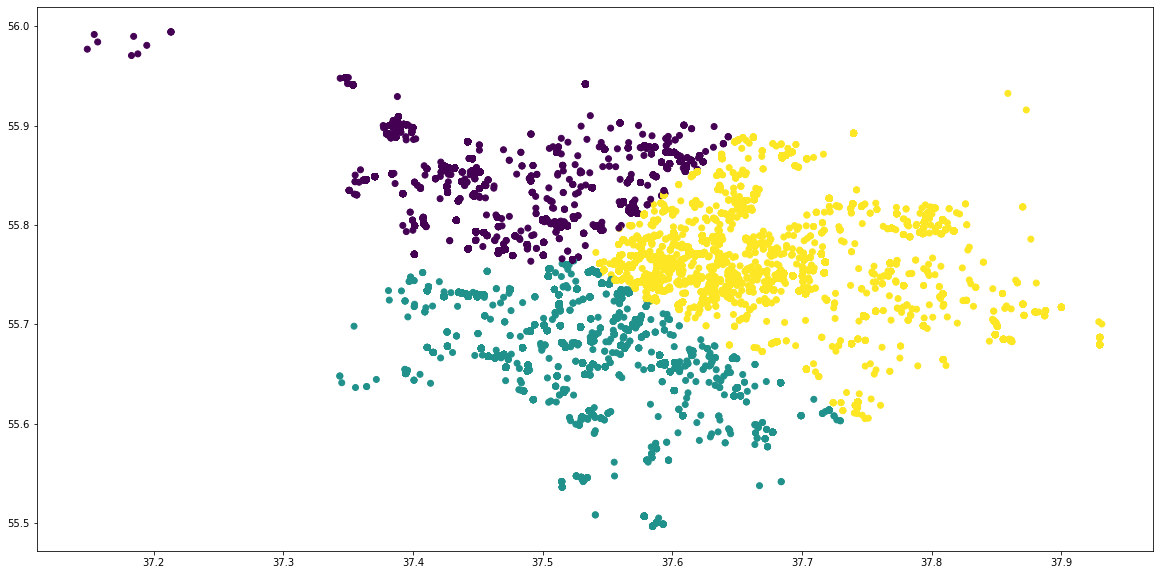

In [24]:
kmeans = KMeans(n_clusters=k_opt)
kmeans.fit(X_scaled)

plt.scatter(X['x'], X['y'], c=kmeans.labels_)
plt.show()